In [1]:
%load_ext autoreload
%autoreload 2
import json
from scipy import sparse
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import string
import scipy.stats as stats

# We must run scripts on Terrier with the parameters!

### So we run:

* Run the weights and queries in Terrier to get the reuslts file
    - bash rcv1-run-top5-idf-p-alpha.sh and variants (in terrier-core-4.2)
    - bin/trec_terrier.sh -r -Dtrec.model=models.BM25PAlpha  -Dbm25p.p=\$p -Dbm25p.alpha=\$alpha -Dbm25p.w
* Interpret the *.res file and see the position of the correct document for each query
    - bash eval-all.sh which calls
    - python eval-scoring-function-on-query-set-sample.py -i \$FILENAME -o ../results/TerrierOutput/eval/\$BASENAME.txt -t \$QT

# How we do it

#### Scoring functions to evaluate:
    - BM25 
    - BM25P10-top5-idf 
    - BM25P10-top5-tfidf 
    - BM25P10-top10-idf 
    - BM25P10-top10-tfidf

For each scoring function result file we evaluate the 4 query types (A,B,C and D). We have some intermediate files from which we read the position of the corrent doc match. We evaluate if in top 1,10,100.

What are the metrics we are interested in?
- Win/loss ratio
- Average rank
- Precision @ 1,10,100
- MRR

There might be some queries in the input files with no results

In [3]:
def loadJSON(sampleFilename):
    with open(sampleFilename) as json_data:
        sample_10000 = json.load(json_data)
    return sample_10000

## Metrics

In [4]:
def averageRank(rank_list):
    return np.sum(rank_list)/10000

In [5]:
def winLossRatio(rank_list, interval = [0,1]):
    correct_class = [r for r in rank_list if r >= interval[0] and r < interval[1]]
#     print(len(correct_class),len(rank_list))
    if len(correct_class) == len(rank_list): return "-"
    else: return len(correct_class)/(len(rank_list) - len(correct_class))

In [6]:
def precision(rank, at=10):
    n_rel_retrieved = 0
    if rank <= at:
        n_rel_retrieved = 1
    return n_rel_retrieved/at

In [7]:
def avgPrecision(rank_list, at=1):
    prec_list = [precision(r, at) for r in rank_list]
    return np.mean(prec_list)

In [8]:
def MRR(rank_list, at=None):
    if at is not None:
        inverse_ranks = [1./x for x in rank_list if x <= at]
    else:
        inverse_ranks = [1./x for x in rank_list]
#     print(len(rank_list))
    return np.sum(inverse_ranks)/10000

In [9]:
def RR(rank_list, at=None):
    if at is not None:
        inverse_ranks = [1./x for x in rank_list if x <= at]
    else:
        inverse_ranks = [1./x for x in rank_list]
#     print(len(rank_list))
    return inverse_ranks

In [9]:
### http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-24.html

In [10]:
def two_sample_ttest_ind(a,b):
    return stats.ttest_ind(a, b, equal_var=False)

In [11]:
def paired_ttest_rel(a, b):
    return stats.ttest_rel(a, b)

In [12]:
intervals = [[0,1], [1,10], [10,100], [100,1000]]

def getMetrics(ranks, positions, interval):
    print("Avg. rank:", averageRank(ranks))
    print("Win/loss", winLossRatio(positions, interval))
    print("Avg. P@1", avgPrecision(ranks, at=1))
    print("Avg. P@10", avgPrecision(ranks, at=10))
    print("Avg. P@100", avgPrecision(ranks, at=100))
    print("Avg. P@1000", avgPrecision(ranks, at=1000))
    print("MRR", MRR(ranks))

# EVAL 

In [13]:
queryTypes = ["A", "B", "C", "D"]

In [14]:
def getQueryTypeSets(positions):
    A = [x for x in positions if x==0]
    B = [x for x in positions if x>0 and x<10]
    C = [x for x in positions if x>=10 and x<100]
    D = [x for x in positions if x>=100 and x<1000]
    print("A",len(A))
    print("B", len(B))
    print("C",len(C))
    print("D", len(D))

In [15]:
def getQueryTypeSetsInline(positions):
    A = [x for x in positions if x==0]
    B = [x for x in positions if x>0 and x<10]
    C = [x for x in positions if x>=10 and x<100]
    D = [x for x in positions if x>=100 and x<1000]
#     return " , ".join([str(len(A)),str(len(B)),str(len(C)), str(len(D)), str(10000-len(A) -len(B)-len(C)-len(D))])
    return len(A), len(B), len(C), len(D)


### BM25

In [17]:
def evalBM25(filename, qt):
    
    Bm25queryRankDict = loadJSON(filename)

    positions = list(Bm25queryRankDict.values())
    ranks = [x+1 for x in positions]
    
    #pretty print, but no data
    getMetrics(ranks, positions, interval=intervals[queryTypes.index(qt)])
    getQueryTypeSets(positions)
    
    #get some data
    bm25_mrr = MRR(ranks)
    bm25_avg_ranks = np.sum(ranks)/10000
    bm25_query_class = getQueryTypeSetsInline(positions)
#     print(bm25_mrr)
#     print(bm25_query_class)
    
    return bm25_mrr, bm25_avg_ranks, bm25_query_class

In [18]:
bm25_mrr_dict = dict()
bm25_avg_rank_dict = dict()
for qt in queryTypes:
    print(qt)
    filename = "../results/TerrierOutput/eval/BM25P-RCV1-bm25-plain-sample-10000-"+qt+"-p-10-alpha-0.txt"
    bm25_mrr, bm25_avg_ranks, bm25_query_class = evalBM25(filename, qt)
    bm25_mrr_dict[("bm25-plain", qt)] = bm25_mrr
    bm25_avg_rank_dict[("bm25-plain", qt)] = bm25_avg_ranks
    print()

A
Avg. rank: 1.0
Win/loss -
Avg. P@1 1.0
Avg. P@10 0.10000000000000002
Avg. P@100 0.01
Avg. P@1000 0.0010000000000000005
MRR 1.0
A 10000
B 0
C 0
D 0

B
Avg. rank: 4.0607
Win/loss -
Avg. P@1 0.0
Avg. P@10 0.10000000000000002
Avg. P@100 0.01
Avg. P@1000 0.0010000000000000005
MRR 0.31975464285714283
A 0
B 10000
C 0
D 0

C
Avg. rank: 37.7498
Win/loss -
Avg. P@1 0.0
Avg. P@10 0.0
Avg. P@100 0.01
Avg. P@1000 0.0010000000000000005
MRR 0.03888721030318724
A 0
B 0
C 10000
D 0

D
Avg. rank: 338.6871
Win/loss -
Avg. P@1 0.0
Avg. P@10 0.0
Avg. P@100 0.0
Avg. P@1000 0.0010000000000000005
MRR 0.0042999992032543765
A 0
B 0
C 0
D 10000



In [33]:
bm25_mrr_dict 

np.mean(list(bm25_mrr_dict.values()))

0.3407354630908961

In [20]:
print(np.mean(list(bm25_avg_rank_dict.values())))
bm25_avg_rank_dict

95.3744


{('bm25-plain', 'A'): 1.0,
 ('bm25-plain', 'B'): 4.0607,
 ('bm25-plain', 'C'): 37.7498,
 ('bm25-plain', 'D'): 338.6871}

### BM25P 

In [21]:
# Settings
dirEval = "../results/TerrierOutput/eval/"
baseTypes = ["top5-idf", 
             "top5-tfidf",
             "top10-idf",
             "top10-tfidf"]
queryTypes = ["A", "B", "C", "D"]
ending = ".txt" # sometimes res


prettyNames={"top5-idf":"BM25P Top-5-IDF", "top5-tfidf":"BM25P Top-5-TFIDF", 
            "top10-idf":"BM25P Top-10-IDF", "top10-tfidf":"BM25P Top-10-TFIDF"}

### MRR plots for different alpha

In [64]:
import os

mrr_dict = defaultdict(list)
rr_dict = defaultdict(list)
average_rank_dict = defaultdict(list)
rank_dict = defaultdict(list)
for filename in os.listdir(dirEval):
    if "10000" in filename:
        name_items = filename.split("-")
        baseType = name_items[2]+"-"+name_items[3]
        alpha = filename.split(".")[0].split("-")[10]

        queryRankDict = loadJSON(dirEval+filename)
        positions = list(queryRankDict.values())
        ranks = [x+1 for x in positions]
        mrr_dict[(baseType, name_items[6])].append(((int(alpha)), MRR(ranks)))
        rr_dict[(baseType, name_items[6])].append(((int(alpha)), RR(ranks)))
        average_rank_dict[(baseType, name_items[6])].append(((int(alpha)), np.sum(ranks)/10000))
        rank_dict[(baseType, name_items[6])].append(((int(alpha)), ranks))

In [65]:
print(mrr_dict.keys())

dict_keys([('top5-tfidf', 'A'), ('top5-idf', 'A'), ('top5-tfidf', 'C'), ('top10-idf', 'B'), ('top10-tfidf', 'A'), ('top5-tfidf', 'D'), ('top10-idf', 'C'), ('top10-tfidf', 'C'), ('top5-tfidf', 'B'), ('top5-idf', 'D'), ('bm25-plain', 'A'), ('top5-idf', 'B'), ('top10-tfidf', 'D'), ('top10-tfidf', 'B'), ('top10-idf', 'A'), ('top10-idf', 'D'), ('top5-idf', 'C'), ('bm25-plain', 'B'), ('bm25-plain', 'D'), ('bm25-plain', 'C')])


In [72]:
print(len(rr_dict[('top5-idf', 'D')]))
print(len(rr_dict[('top5-idf', 'D')][5][1]))

print(np.sum(rr_dict[('top5-idf', 'D')][5][1])/9364)

print(mrr_dict[('top5-idf', 'D')][5])

print(len(rank_dict[('top5-idf', 'D')][5][1]))

11
9364
0.015372404614068944
(25, 0.014394719680614159)
9364


In [73]:
# # JUST FOR PRINTING 

for alpha in [10, 15, 20, 25]:
    for baseType in baseTypes:
        print(alpha, baseType, end=" ")
        vals = []
        for queryType in queryTypes:
            key = (baseType, queryType)
            mrr = [y for x,y in mrr_dict[baseType, queryType] if x==alpha]
#             print(queryType, mrr, end=" ")
            vals.append(mrr[0])
#         print()
#         print(vals)
#         print()
        print(" & ".join([str("{:.3f}".format(i)) for i in vals]))
#         print()
    print()

10 top5-idf 0.930 & 0.424 & 0.087 & 0.012
10 top5-tfidf 0.980 & 0.391 & 0.057 & 0.006
10 top10-idf 0.965 & 0.393 & 0.060 & 0.007
10 top10-tfidf 0.987 & 0.369 & 0.049 & 0.005

15 top5-idf 0.941 & 0.429 & 0.091 & 0.013
15 top5-tfidf 0.976 & 0.399 & 0.063 & 0.007
15 top10-idf 0.965 & 0.400 & 0.066 & 0.008
15 top10-tfidf 0.981 & 0.380 & 0.054 & 0.006

20 top5-idf 0.940 & 0.428 & 0.092 & 0.014
20 top5-tfidf 0.968 & 0.400 & 0.067 & 0.008
20 top10-idf 0.960 & 0.404 & 0.069 & 0.009
20 top10-tfidf 0.971 & 0.382 & 0.059 & 0.007

25 top5-idf 0.936 & 0.424 & 0.092 & 0.014
25 top5-tfidf 0.959 & 0.399 & 0.069 & 0.009
25 top10-idf 0.952 & 0.401 & 0.071 & 0.009
25 top10-tfidf 0.963 & 0.381 & 0.061 & 0.007



In [74]:
def plot_and_sort(baseType, mrr_dict, bm25_mrr_dict, queryTypes):
    for queryType in queryTypes:
        key = (baseType, queryType)
        mrr_list = mrr_dict[key]
        #print(sorted(mrr_list, key=lambda tup: tup[0]))
        x = [x for x,y in sorted(mrr_list, key=lambda tup: tup[0])]
        y = [y for x,y in sorted(mrr_list, key=lambda tup: tup[0])]
#         print(x)
        print(y)
        plt.plot(x,y , label=prettyNames[key[0]] + " " + key[1])
        #print(max(y),x[y.index(max(y))])
#         plt.plot(x[y.index(max(y))], max(y), "or")
        # print bm25 as baseline
        baseline_y = [bm25_mrr_dict[("bm25-plain", queryType)]] * len(x)
#         print(baseline_y)
        plt.plot(x, baseline_y, label="BM25 " + str(queryType), linestyle="--")
#         print()
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.legend(loc='upper right')
#     plt.title("BM25P varying alpha")
    plt.xlabel("Alpha")
    plt.ylabel("MRR@1000")
#     plt.axis([5,25,0,20]) # this is for zooming in
    plt.savefig("RCV1-BM25-vary-alpha-"+baseType+".pdf", bbox_inches='tight')
    plt.show()
    return plt

[0.696106663780798, 0.8928932032863102, 0.9303515645227802, 0.9405244448871701, 0.9401004282197227, 0.9355745418177454, 0.9307321125564832, 0.9263965536143647, 0.9205262151801428, 0.9158064183786567, 0.9112254130904097]
[0.2717696675570656, 0.3969292574601577, 0.42400201589340103, 0.4285201363963482, 0.42787072322883185, 0.42446152738886933, 0.4216805240455147, 0.4186346430704314, 0.4136112136617573, 0.4104009053149764, 0.40758671133239716]
[0.04950607092759589, 0.07721870064229781, 0.08700094045441435, 0.09069415622855856, 0.09185171743387048, 0.09168397017021886, 0.09069056093346055, 0.09015749395964834, 0.0897583212038626, 0.08864932200570556, 0.08822522586987888]
[0.006226511687070268, 0.009232594153741286, 0.011749141898409704, 0.013175426032875245, 0.013917243445495359, 0.014394719680614159, 0.014669016838335642, 0.014769052238705435, 0.014719906735418915, 0.014725092959098384, 0.014686339157432934]


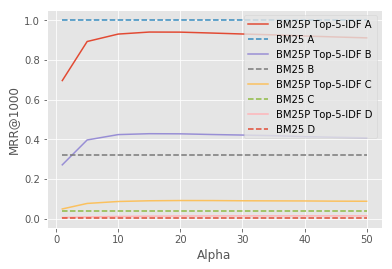

[0.7489989139948647, 0.9530867352628449, 0.9799088045923058, 0.9760923862798707, 0.9678600099960238, 0.9593669387595548, 0.9508225023155843, 0.9439054298592038, 0.9369857558184154, 0.9312288419880966, 0.9262380230142584]
[0.24760141840148608, 0.366941724863623, 0.3911080486302816, 0.39941539427664075, 0.3999305685934693, 0.3987383663874112, 0.3938223384539904, 0.3910197685262739, 0.388130834604488, 0.38224689088695446, 0.3801831505383189]
[0.03644766424425213, 0.049566644347722406, 0.0571737198325924, 0.06334438778285395, 0.06692979101658927, 0.06860659334312032, 0.07000463153153719, 0.07023211191111005, 0.06982451544231057, 0.07006157661471397, 0.06963869331436144]
[0.004382129760765504, 0.0053309751847315096, 0.006253939373519502, 0.007227958683232785, 0.007946029895130139, 0.008572281029897717, 0.009367459498985072, 0.009757346816508763, 0.009958018447674006, 0.010302942433669563, 0.010352989976586622]


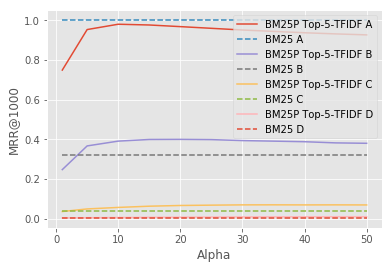

[0.7208345625540842, 0.9331454676577545, 0.9649069243102784, 0.9653541983893299, 0.9596079077355393, 0.9521836534443606, 0.9453146875019293, 0.9379176501481852, 0.9308535649052873, 0.924559490394502, 0.9202010975842064]
[0.24394613783556374, 0.3637918715705343, 0.3928821976604951, 0.40007937746549976, 0.4036329440115491, 0.4014722514654663, 0.3981647391472376, 0.3941199247919163, 0.3905634336646937, 0.3872717792135066, 0.38417073625942505]
[0.036730740442403695, 0.051426051774308236, 0.060010035191452496, 0.06583487679325087, 0.0689359822039241, 0.0706365703192202, 0.07156940359132488, 0.0717951502665108, 0.07197132515725288, 0.07195771844997409, 0.07170258979302475]
[0.004510683621039615, 0.005642844448704683, 0.006707802485569965, 0.007797226072334132, 0.008516382487487909, 0.009193026011772916, 0.009992455117218697, 0.010254626213015743, 0.010601943569578972, 0.010721294539721756, 0.010784879392926492]


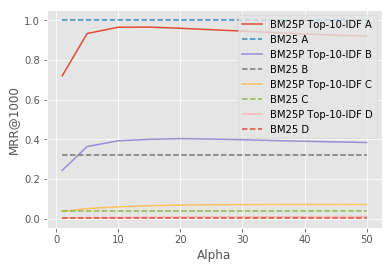

[0.7435387982198793, 0.9571931963078072, 0.9868976970203286, 0.9808906701583017, 0.9713534277227984, 0.9629253280694696, 0.9538540286462379, 0.9455972941516593, 0.9387705099130194, 0.9330862463744317, 0.9280518071416396]
[0.23474175691335608, 0.3443407641253256, 0.36903733764020524, 0.38031094591974796, 0.3818464721592416, 0.38082493081670216, 0.3787228008169089, 0.3754531041036752, 0.37117656816848626, 0.368845529040754, 0.36508595666821914]
[0.03299239564566264, 0.0431080487542538, 0.04857835051853733, 0.054150002974047075, 0.058503977724385994, 0.061286121619543284, 0.06262273941236347, 0.06346064320049544, 0.06375438418023528, 0.06369788994004759, 0.0637481433085881]
[0.0038870989987412116, 0.004642832040249811, 0.00537916729062166, 0.0060842797042825435, 0.006792371811432771, 0.007319080726295138, 0.00775958770627672, 0.008279725495035438, 0.00878550977457609, 0.00906637923128578, 0.009193357567475626]


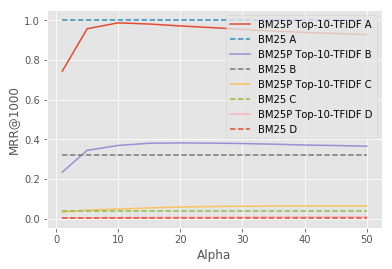

In [75]:
plt.style.use("ggplot")
for baseType in baseTypes:
    plot_and_sort(baseType, mrr_dict, bm25_mrr_dict, queryTypes)

In [76]:
print(rr_dict.keys())

dict_keys([('top5-tfidf', 'A'), ('top5-idf', 'A'), ('top5-tfidf', 'C'), ('top10-idf', 'B'), ('top10-tfidf', 'A'), ('top5-tfidf', 'D'), ('top10-idf', 'C'), ('top10-tfidf', 'C'), ('top5-tfidf', 'B'), ('top5-idf', 'D'), ('bm25-plain', 'A'), ('top5-idf', 'B'), ('top10-tfidf', 'D'), ('top10-tfidf', 'B'), ('top10-idf', 'A'), ('top10-idf', 'D'), ('top5-idf', 'C'), ('bm25-plain', 'B'), ('bm25-plain', 'D'), ('bm25-plain', 'C')])


In [60]:
def check_statistical_significance_with_baseline(baseType, rr_dict, mrr_dict, queryTypes):
    """
    base type : 'top5-idf' ...
    query type : 'A', 'B' ...
    
    """
    for queryType in queryTypes:
        key = (baseType, queryType)
        print("\x1b[0m " + str(key))
        
        rr_list = rr_dict[key]
        sorted_rr_list = sorted(rr_list, key=lambda tup: tup[0])
#         print(sorted_rr_list) # list of (alpha, rr_list)
#         print([x for x,y in sorted_rr_list])
        
        
        base_rr_list = rr_dict[("bm25-plain", queryType)]
        sorted_base_rr_list = sorted(base_rr_list, key=lambda tup: tup[0])
#         print(sorted_base_rr_list) # list of (alpha, rr_list) 
#         print([x for x,y in sorted_base_rr_list])
        

        
        for first in sorted_rr_list:
            print("\x1b[0m " + str(first[0]) + " " + str(sorted_base_rr_list[0][0]), end= " ")
            print(np.mean(first[1]), np.mean(sorted_base_rr_list[0][1]))
            result = two_sample_ttest_ind(first[1], sorted_base_rr_list[0][1])
            print(result)
            print("\x1b[31m Statistically diff" if result[1]<0.05 else "\033[34m NOT statistically different")
        
        print()


In [61]:
for baseType in baseTypes:
    check_statistical_significance_with_baseline(baseType, rr_dict, mrr_dict, queryTypes)

 ('top5-idf', 'A')
 1 0 0.6969429953752484 1.0
Ttest_indResult(statistic=-78.7940874418545, pvalue=0.0)
 Statistically diff
 5 0 0.8928932032863102 1.0
Ttest_indResult(statistic=-43.0247732917986, pvalue=0.0)
 Statistically diff
 10 0 0.9303515645227802 1.0
Ttest_indResult(statistic=-35.342507747195825, pvalue=6.205617719850299e-258)
 Statistically diff
 15 0 0.9405244448871701 1.0
Ttest_indResult(statistic=-32.90903839829872, pvalue=1.3183975392404797e-225)
 Statistically diff
 20 0 0.9401004282197227 1.0
Ttest_indResult(statistic=-32.903971848714995, pvalue=1.5326329942162498e-225)
 Statistically diff
 25 0 0.9355745418177454 1.0
Ttest_indResult(statistic=-34.218933166314415, pvalue=8.808948209888873e-243)
 Statistically diff
 30 0 0.9307321125564832 1.0
Ttest_indResult(statistic=-35.370452431093184, pvalue=2.576739209679496e-258)
 Statistically diff
 35 0 0.9263965536143647 1.0
Ttest_indResult(statistic=-36.32725724327365, pvalue=1.5890281291112876e-271)
 Statistically diff
 40 0 0.

Ttest_indResult(statistic=24.97237409304917, pvalue=4.254057645285053e-135)
 Statistically diff
 15 0 0.39941539427664075 0.31975464285714283
Ttest_indResult(statistic=26.88925284245208, pvalue=9.265282504374859e-156)
 Statistically diff
 20 0 0.3999305685934693 0.31975464285714283
Ttest_indResult(statistic=26.418841810132854, pvalue=1.7581358164003416e-150)
 Statistically diff
 25 0 0.3987383663874112 0.31975464285714283
Ttest_indResult(statistic=25.45870418595806, pvalue=4.713076353681707e-140)
 Statistically diff
 30 0 0.3938223384539904 0.31975464285714283
Ttest_indResult(statistic=23.671665699768603, pvalue=1.1349830446348221e-121)
 Statistically diff
 35 0 0.3910197685262739 0.31975464285714283
Ttest_indResult(statistic=22.5196320697492, pvalue=1.7881329159829193e-110)
 Statistically diff
 40 0 0.388130834604488 0.31975464285714283
Ttest_indResult(statistic=21.4012445437559, pvalue=4.1509138208268706e-100)
 Statistically diff
 45 0 0.38224689088695446 0.31975464285714283
Ttest_in

 Statistically diff
 45 0 0.07197211287254861 0.03888721030318724
Ttest_indResult(statistic=24.66218049312591, pvalue=1.2402886808870544e-130)
 Statistically diff
 50 0 0.07174563717532995 0.03888721030318724
Ttest_indResult(statistic=24.25642383596527, pvalue=1.5331099250709696e-126)
 Statistically diff

 ('top10-idf', 'D')
 1 0 0.0062552816822072045 0.0042999992032543765
Ttest_indResult(statistic=6.39980238091508, pvalue=1.6519746473001082e-10)
 Statistically diff
 5 0 0.005995372342440165 0.0042999992032543765
Ttest_indResult(statistic=18.425000231951067, pvalue=1.144595790707078e-74)
 Statistically diff
 10 0 0.006914547454458267 0.0042999992032543765
Ttest_indResult(statistic=25.353672969867176, pvalue=8.14546035382777e-138)
 Statistically diff
 15 0 0.008046672933265359 0.0042999992032543765
Ttest_indResult(statistic=21.109776621996577, pvalue=7.993053506171813e-97)
 Statistically diff
 20 0 0.008896252467865778 0.0042999992032543765
Ttest_indResult(statistic=19.239289921216724, 

# Average RANK 

In [62]:
# for baseType in baseTypes:
#     a = plot_and_sort(baseType, average_rank_dict, bm25_avg_rank_dict, queryTypes)

In [63]:
def check_statistical_significance_with_baseline(baseType, rank_dict,  queryTypes):
    """
    base type : 'top5-idf' ...
    query type : 'A', 'B' ...
    
    """
    for queryType in queryTypes:
        key = (baseType, queryType)
        print("\x1b[0m " + str(key))
        
        r_list = rank_dict[key]
        sorted_r_list = sorted(r_list, key=lambda tup: tup[0])
#         print(sorted_r_list) # list of (alpha, rr_list)
#         print([x for x,y in sorted_rr_list])
        
        
        base_r_list = rank_dict[("bm25-plain", queryType)]
        sorted_base_r_list = sorted(base_r_list, key=lambda tup: tup[0])
#         print(sorted_base_r_list) # list of (alpha, rr_list) 
#         print([x for x,y in sorted_base_rr_list])
        

        for first in sorted_r_list:
            print("\x1b[0m " + str(first[0]) + " " + str(sorted_base_r_list[0][0]), end= " ")
            print(np.mean(first[1]), np.mean(sorted_base_r_list[0][1]))
            result = two_sample_ttest_ind(first[1], sorted_base_r_list[0][1])
            print(result)
            print("\x1b[31m Statistically diff" if result[1]<0.05 else "\033[34m NOT statistically different")
        
        print()


In [ ]:
for baseType in baseTypes:
    check_statistical_significance_with_baseline(baseType, rank_dict, queryTypes)

In [77]:
for baseType in baseTypes:

    for queryType in queryTypes:
        key = (baseType, queryType)
        avg_rank_list = average_rank_dict[key]
        x = [x for x,y in sorted(avg_rank_list, key=lambda tup: tup[0])]
        y = [y for x,y in sorted(avg_rank_list, key=lambda tup: tup[0])]

        avg_rank_bm25 = bm25_avg_rank_dict[("bm25-plain", queryType)]
        #for i in range(len(y)):
        for i in [2,3,4,5,6]:
            
            print("\x1b[0m "+str(key), x[i], y[i], avg_rank_bm25, end='')
            print("\x1b[31m WIN" if y[i]<avg_rank_bm25 else "\x1b[0m ") 
        print()
        
    print("--------------------------------")

 ('top5-idf', 'A') 10 1.3023 1.0 
 ('top5-idf', 'A') 15 1.2131 1.0 
 ('top5-idf', 'A') 20 1.2188 1.0 
 ('top5-idf', 'A') 25 1.2339 1.0 
 ('top5-idf', 'A') 30 1.2673 1.0 

 ('top5-idf', 'B') 10 4.6595 4.0607 
 ('top5-idf', 'B') 15 4.4058 4.0607 
 ('top5-idf', 'B') 20 4.5222 4.0607 
 ('top5-idf', 'B') 25 4.7526 4.0607 
 ('top5-idf', 'B') 30 5.0312 4.0607 

 ('top5-idf', 'C') 10 38.9933 37.7498 
 ('top5-idf', 'C') 15 37.9241 37.7498 
 ('top5-idf', 'C') 20 39.4428 37.7498 
 ('top5-idf', 'C') 25 41.8497 37.7498 
 ('top5-idf', 'C') 30 44.5672 37.7498 

 ('top5-idf', 'D') 10 238.9855 338.6871 WIN
 ('top5-idf', 'D') 15 245.7502 338.6871 WIN
 ('top5-idf', 'D') 20 249.5892 338.6871 WIN
 ('top5-idf', 'D') 25 250.8906 338.6871 WIN
 ('top5-idf', 'D') 30 253.4171 338.6871 WIN

--------------------------------
 ('top5-tfidf', 'A') 10 1.0572 1.0 
 ('top5-tfidf', 'A') 15 1.0659 1.0 
 ('top5-tfidf', 'A') 20 1.0948 1.0 
 ('top5-tfidf', 'A') 25 1.1292 1.0 
 ('top5-tfidf', 'A') 30 1.1733 1.0 

 ('top5-tfid

BM25 avg rank : 95.3744
top5-idf avg rank[1-50] :  [99.852 74.037 70.985 72.323 73.693 74.682 76.071 77.876 79.264 80.488
 81.324]
top5-tfidf avg rank[1-50] :  [110.355  82.182  77.391  77.335  77.688  78.566  79.955  81.385  82.582
  83.763  84.749]
top10-idf avg rank[1-50] :  [109.149  82.133  76.047  76.982  77.538  79.122  80.005  81.415  82.9
  84.054  84.239]
top10-tfidf avg rank[1-50] :  [109.496  88.233  82.371  80.267  80.28   80.846  81.731  82.598  83.958
  84.961  85.775]


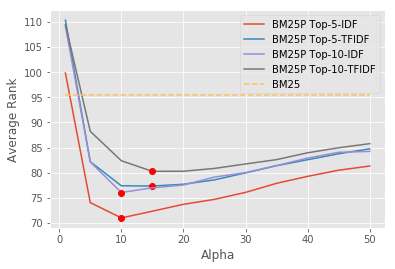

In [78]:
print("BM25 avg rank :", np.mean(list(bm25_avg_rank_dict.values())))

def plot_avg_rank():
    for baseType in baseTypes:
        all_avg_rank = np.zeros(11)
        for queryType in queryTypes:
            key = (baseType, queryType)
            avg_rank_list = average_rank_dict[key]
            x = [x for x,y in sorted(avg_rank_list, key=lambda tup: tup[0])]
            y = [y for x,y in sorted(avg_rank_list, key=lambda tup: tup[0])]
            all_avg_rank += np.array(y)
        print(baseType+ " avg rank[1-50] : ", all_avg_rank/4)
        y_avg = all_avg_rank/4
        
        plt.plot(x,y_avg, label=prettyNames[baseType])
        #print(max(y),x[y.index(max(y))])
        plt.plot(x[list(y_avg).index(min(y_avg))], min(y_avg), "or")
        # print bm25 as baseline
    baseline_y = [np.mean(list(bm25_avg_rank_dict.values()))] * len(x)
    plt.plot(x, baseline_y, label="BM25", linestyle="--")
    plt.legend(loc='upper right')
    plt.xlabel("Alpha")
    plt.ylabel("Average Rank")
    plt.savefig("RCV1-BM25-avg-rank.pdf", bbox_inches='tight')
    plt.show()
    
plot_avg_rank()  


BM25 avg mrr : 0.3407354630908961
top5-idf avg rank[1-50] :  [0.256 0.344 0.363 0.368 0.368 0.367 0.364 0.362 0.36  0.357 0.355]
top5-tfidf avg rank[1-50] :  [0.259 0.344 0.359 0.362 0.361 0.359 0.356 0.354 0.351 0.348 0.347]
top10-idf avg rank[1-50] :  [0.252 0.339 0.356 0.36  0.36  0.358 0.356 0.354 0.351 0.349 0.347]
top10-tfidf avg rank[1-50] :  [0.254 0.337 0.352 0.355 0.355 0.353 0.351 0.348 0.346 0.344 0.342]


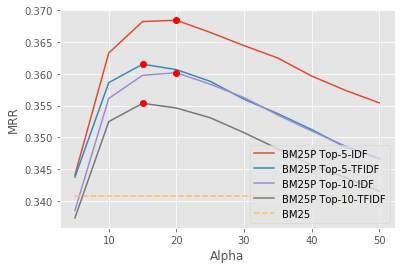

In [79]:
print("BM25 avg mrr :", np.mean(list(bm25_mrr_dict.values())))
np.set_printoptions(precision=3)

def plot_avg_mrr():
    for baseType in baseTypes:
        all_avg_mrr = np.zeros(11)
        for queryType in queryTypes:
            key = (baseType, queryType)
            mrr_list = mrr_dict[key]
            x = [x for x,y in sorted(mrr_list, key=lambda tup: tup[0])]
            y = [y for x,y in sorted(mrr_list, key=lambda tup: tup[0])]
            all_avg_mrr += np.array(y)
        print(baseType+ " avg rank[1-50] : ", all_avg_mrr/4)
        y_avg = all_avg_mrr/4
        
        plt.plot(x[1:],y_avg[1:], label=prettyNames[baseType])
        #print(max(y),x[y.index(max(y))])
        plt.plot(x[list(y_avg).index(max(y_avg))], max(y_avg), "or")
        # print bm25 as baseline
    baseline_y = [np.mean(list(bm25_mrr_dict.values()))] * len(x)
    plt.plot(x[1:], baseline_y[1:], label="BM25", linestyle="--")
    plt.legend(loc='lower right')
    plt.xlabel("Alpha")
    plt.ylabel("MRR")
    plt.savefig("RCV1-BM25-avg-mrr.pdf", bbox_inches='tight')
    plt.show()
    
plot_avg_mrr() 


# Statistical significance for MRR values

In [80]:
print(rr_dict.keys())

dict_keys([('top5-tfidf', 'A'), ('top5-idf', 'A'), ('top5-tfidf', 'C'), ('top10-idf', 'B'), ('top10-tfidf', 'A'), ('top5-tfidf', 'D'), ('top10-idf', 'C'), ('top10-tfidf', 'C'), ('top5-tfidf', 'B'), ('top5-idf', 'D'), ('bm25-plain', 'A'), ('top5-idf', 'B'), ('top10-tfidf', 'D'), ('top10-tfidf', 'B'), ('top10-idf', 'A'), ('top10-idf', 'D'), ('top5-idf', 'C'), ('bm25-plain', 'B'), ('bm25-plain', 'D'), ('bm25-plain', 'C')])


## two pample paired - IND

In [81]:
def check_statistical_significance(baseType, rr_dict, mrr_dict, queryTypes):
    """
    base type : 'top5-idf' ...
    query type : 'A', 'B' ...
    
    """
    for queryType in queryTypes:
        key = (baseType, queryType)
        print(key)
        
        rr_list = rr_dict[key]
        sorted_rr_list = sorted(rr_list, key=lambda tup: tup[0])
        
        mrr_list = mrr_dict[key]
        #print(sorted(mrr_list, key=lambda tup: tup[0]))
        x = [x for x,y in sorted(mrr_list, key=lambda tup: tup[0])]
        y = [y for x,y in sorted(mrr_list, key=lambda tup: tup[0])]
        max_index = x[y.index(max(y))]
        
        for first, second in zip(sorted_rr_list, sorted_rr_list[1:]):
            print(first[0], second[0])
            print(y[x.index(first[0])], y[x.index(second[0])])
            print(two_sample_ttest_ind(first[1], second[1]))

In [82]:
def check_statistical_significance_with_max(baseType, rr_dict, mrr_dict, queryTypes):
    """
    base type : 'top5-idf' ...
    query type : 'A', 'B' ...
    
    """
    for queryType in queryTypes:
        key = (baseType, queryType)
        print(key)
        
        rr_list = rr_dict[key]
        sorted_rr_list = sorted(rr_list, key=lambda tup: tup[0])
        
        mrr_list = mrr_dict[key]
        #print(sorted(mrr_list, key=lambda tup: tup[0]))
        x = [x for x,y in sorted(mrr_list, key=lambda tup: tup[0])]
        y = [y for x,y in sorted(mrr_list, key=lambda tup: tup[0])]
        max_alpha = x[y.index(max(y))]
        print(max_alpha)
        max_rrs = sorted_rr_list[x.index(max_alpha)][1]
        
        for first in sorted_rr_list:
            print(first[0], max_alpha)
            print(y[x.index(first[0])], y[x.index(max_alpha)])
            print(two_sample_ttest_ind(first[1], max_rrs))

In [83]:
check_statistical_significance_with_max('top5-idf', rr_dict, mrr_dict, queryTypes)

('top5-idf', 'A')
15
1 15
0.696106663780798 0.9405244448871701
Ttest_indResult(statistic=-57.31819495976065, pvalue=0.0)
5 15
0.8928932032863102 0.9405244448871701
Ttest_indResult(statistic=-15.483430586061273, pvalue=9.862013097427319e-54)
10 15
0.9303515645227802 0.9405244448871701
Ttest_indResult(statistic=-3.8045024890927857, pvalue=0.0001425155034847025)
15 15
0.9405244448871701 0.9405244448871701
Ttest_indResult(statistic=0.0, pvalue=1.0)
20 15
0.9401004282197227 0.9405244448871701
Ttest_indResult(statistic=-0.16529619591619138, pvalue=0.8687125237545502)
25 15
0.9355745418177454 0.9405244448871701
Ttest_indResult(statistic=-1.8966746473848275, pvalue=0.057885311839210564)
30 15
0.9307321125564832 0.9405244448871701
Ttest_indResult(statistic=-3.6746393278480194, pvalue=0.00023881166237388007)
35 15
0.9263965536143647 0.9405244448871701
Ttest_indResult(statistic=-5.203582013404242, pvalue=1.974384757471688e-07)
40 15
0.9205262151801428 0.9405244448871701
Ttest_indResult(statistic=

In [84]:
for baseType in baseTypes:
    check_statistical_significance_with_max(baseType, rr_dict, mrr_dict, queryTypes)

('top5-idf', 'A')
15
1 15
0.696106663780798 0.9405244448871701
Ttest_indResult(statistic=-57.31819495976065, pvalue=0.0)
5 15
0.8928932032863102 0.9405244448871701
Ttest_indResult(statistic=-15.483430586061273, pvalue=9.862013097427319e-54)
10 15
0.9303515645227802 0.9405244448871701
Ttest_indResult(statistic=-3.8045024890927857, pvalue=0.0001425155034847025)
15 15
0.9405244448871701 0.9405244448871701
Ttest_indResult(statistic=0.0, pvalue=1.0)
20 15
0.9401004282197227 0.9405244448871701
Ttest_indResult(statistic=-0.16529619591619138, pvalue=0.8687125237545502)
25 15
0.9355745418177454 0.9405244448871701
Ttest_indResult(statistic=-1.8966746473848275, pvalue=0.057885311839210564)
30 15
0.9307321125564832 0.9405244448871701
Ttest_indResult(statistic=-3.6746393278480194, pvalue=0.00023881166237388007)
35 15
0.9263965536143647 0.9405244448871701
Ttest_indResult(statistic=-5.203582013404242, pvalue=1.974384757471688e-07)
40 15
0.9205262151801428 0.9405244448871701
Ttest_indResult(statistic=

40 35
0.06982451544231057 0.07023211191111005
Ttest_indResult(statistic=-0.2289315140504451, pvalue=0.8189244874051106)
45 35
0.07006157661471397 0.07023211191111005
Ttest_indResult(statistic=-0.08409982347327068, pvalue=0.9329779079605774)
50 35
0.06963869331436144 0.07023211191111005
Ttest_indResult(statistic=-0.3057215087987465, pvalue=0.7598198834811738)
('top5-tfidf', 'D')
50
1 50
0.004382129760765504 0.010352989976586622
Ttest_indResult(statistic=-9.40146893275852, pvalue=6.207108054123108e-21)
5 50
0.0053309751847315096 0.010352989976586622
Ttest_indResult(statistic=-11.447513232458471, pvalue=3.846241650930621e-30)
10 50
0.006253939373519502 0.010352989976586622
Ttest_indResult(statistic=-9.938804581962952, pvalue=3.667398737897201e-23)
15 50
0.007227958683232785 0.010352989976586622
Ttest_indResult(statistic=-7.6840611656402125, pvalue=1.6796236378871933e-14)
20 50
0.007946029895130139 0.010352989976586622
Ttest_indResult(statistic=-5.870745739530228, pvalue=4.457424140827805e

15 40
0.054150002974047075 0.06375438418023528
Ttest_indResult(statistic=-7.445829219923696, pvalue=1.0126064452721577e-13)
20 40
0.058503977724385994 0.06375438418023528
Ttest_indResult(statistic=-3.7496815128773657, pvalue=0.0001775962362317794)
25 40
0.061286121619543284 0.06375438418023528
Ttest_indResult(statistic=-1.6690925220439772, pvalue=0.09511500892393719)
30 40
0.06262273941236347 0.06375438418023528
Ttest_indResult(statistic=-0.7456176017249933, pvalue=0.4559072621316467)
35 40
0.06346064320049544 0.06375438418023528
Ttest_indResult(statistic=-0.19255135193260453, pvalue=0.8473123047109556)
40 40
0.06375438418023528 0.06375438418023528
Ttest_indResult(statistic=0.0, pvalue=1.0)
45 40
0.06369788994004759 0.06375438418023528
Ttest_indResult(statistic=-0.02739757313360822, pvalue=0.978142907395246)
50 40
0.0637481433085881 0.06375438418023528
Ttest_indResult(statistic=0.015916407245863018, pvalue=0.9873012396007033)
('top10-tfidf', 'D')
50
1 50
0.0038870989987412116 0.0091933

# T-test for 2 related sample scores
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html#scipy.stats.ttest_rel

In [85]:
def check_statistical_significance_with_baseline(baseType, rr_dict, mrr_dict, queryTypes):
    """
    base type : 'top5-idf' ...
    query type : 'A', 'B' ...
    
    """
    for queryType in queryTypes:
        key = (baseType, queryType)
        print(key)
        
        rr_list = rr_dict[key]
        sorted_rr_list = sorted(rr_list, key=lambda tup: tup[0])
#         print(sorted_rr_list) # list of (alpha, rr_list)
#         print([x for x,y in sorted_rr_list])
        
        
        base_rr_list = rr_dict[("bm25-plain", queryType)]
        sorted_base_rr_list = sorted(base_rr_list, key=lambda tup: tup[0])
#         print(sorted_base_rr_list) # list of (alpha, rr_list) 
#         print([x for x,y in sorted_base_rr_list])
        

        
        for first in sorted_rr_list:
            print(first[0], sorted_base_rr_list[0][0])
            print(np.mean(first[1]), np.mean(sorted_base_rr_list[0][1]))
            print(two_sample_ttest_ind(first[1], sorted_base_rr_list[0][1]))

In [86]:
# check_statistical_significance_with_baseline('top5-idf', rr_dict, mrr_dict, queryTypes)

#### ALL are statistically different!!!

### WIN/LOSS ratio for varying alpha

In [87]:
import os

class_dict = defaultdict(list)
for filename in os.listdir(dirEval):
    if "10000" in filename:
        name_items = filename.split("-")
        baseType = name_items[2]+"-"+name_items[3]
        alpha = filename.split(".")[0].split("-")[10]

        queryRankDict = loadJSON(dirEval+filename)
        positions = list(queryRankDict.values())
        ranks = [x+1 for x in positions]
        new_class = getQueryTypeSetsInline(positions)
        class_dict[(baseType, name_items[6])].append(((int(alpha)), new_class))

In [88]:
def getWinLossRatio(baseType, queryType, alpha, class_dict):
    line = [(x,y) for (x,y) in class_dict[(baseType, queryType)] if x == alpha][0]
    if queryType == "A":
        losses = sum(line[1][1:])
        wins = []
        for queryType in ["B","C","D"]:
            line = [(x,y) for (x,y) in class_dict[(baseType, queryType)] if x == alpha][0]
            wins.append(line[1][0])
        return sum(wins)/losses
    if queryType == "B":
        losses = sum(line[1][2:])
        wins = []
        for queryType in ["C","D"]:
            line = [(x,y) for (x,y) in class_dict[(baseType, queryType)] if x == alpha][0]
            wins.append(line[1][1])
        return sum(wins)/losses
    if queryType == "C":
        losses = sum(line[1][3:])
        wins = []
        for queryType in ["D"]:
            line = [(x,y) for (x,y) in class_dict[(baseType, queryType)] if x == alpha][0]
            wins.append(line[1][2])
        return sum(wins)/losses
        

In [89]:
getWinLossRatio("top5-idf", "A", 10, class_dict)

1.6786632390745502

In [90]:
win_loss_dict = defaultdict(list) ### the list contains WL for multiple alpha

for baseType in baseTypes:
    for queryType in queryTypes:
        if queryType is not "D":
            for alpha,_ in class_dict[(baseType, queryType)]:
                wl = getWinLossRatio(baseType, queryType, alpha, class_dict)
                win_loss_dict[(baseType, queryType)].append(((int(alpha)), wl))

In [91]:
print(win_loss_dict)

defaultdict(<class 'list'>, {('top5-idf', 'A'): [(20, 2.015655577299413), (40, 1.5544554455445545), (1, 0.27850283181482394), (50, 1.4104166666666667), (30, 1.7611301369863013), (35, 1.684596577017115), (45, 1.4742193173565723), (25, 1.8652094717668488), (10, 1.6786632390745502), (15, 1.9657869012707723), (5, 1.0797101449275361)], ('top5-idf', 'B'): [(50, 1.62015503875969), (30, 2.32776617954071), (20, 2.880050505050505), (45, 1.756198347107438), (25, 2.6039260969976907), (15, 3.1966987620357634), (10, 2.844932844932845), (40, 1.8915343915343916), (1, 0.3241398143091207), (5, 1.5195086705202312), (35, 2.0636882129277567)], ('top5-idf', 'C'): [(5, 1.9134532990574122), (45, 1.4040178571428572), (30, 1.9396551724137931), (50, 1.3111268603827073), (1, 0.4286694101508916), (10, 2.9610894941634243), (20, 2.6649810366624527), (40, 1.5161799526440412), (35, 1.697934595524957), (25, 2.211087420042644), (15, 3.095435684647303)], ('top5-tfidf', 'A'): [(1, 0.221395881006865), (5, 1.212871287128712

In [92]:
def plot_and_sort_WL(baseType, win_loss_dict, queryTypes):
    for queryType in ["A","B","C"]:
        key = (baseType, queryType)
        wl_list = win_loss_dict[key]
#         print(key)
        #print(sorted(mrr_list, key=lambda tup: tup[0]))
        x = [x for x,y in sorted(wl_list, key=lambda tup: tup[0])]
#         print(x)
        y = [y for x,y in sorted(wl_list, key=lambda tup: tup[0])]
#         print(y)
        plt.plot(x, y , label=prettyNames[key[0]]+" "+key[1])
        #print(max(y),x[y.index(max(y))])
#         plt.plot(x[y.index(max(y))], max(y), "or")
    plt.plot(x, [1 for x in range(len(x))], ":k", label="win-loss threshold")
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.legend(loc='upper right')
    plt.xlabel("Alpha")
    plt.ylabel("WinLossRatio")
    plt.savefig("RCV1-BM25-win-loss-"+baseType+".pdf", bbox_inches='tight')
    plt.show()

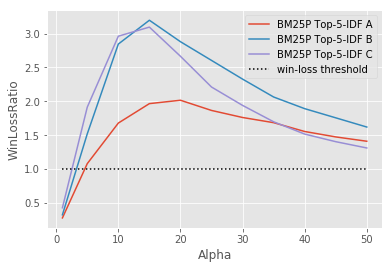

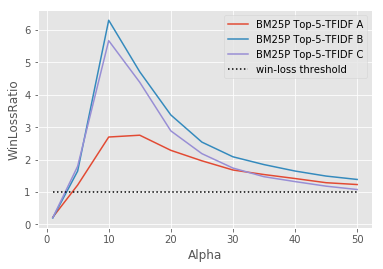

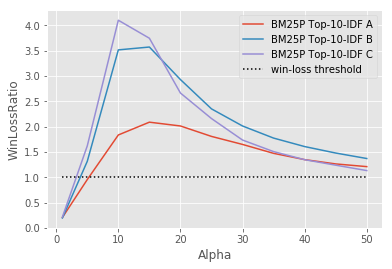

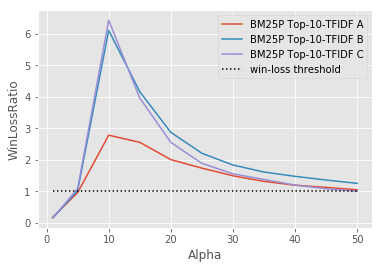

In [93]:
for baseType in baseTypes:
    plot_and_sort_WL(baseType, win_loss_dict, queryTypes)

## Todo:

- intersect qid from wins of C for alpha 10 with wins of C for alpha 40